In [45]:
import numpy as np
from gurobipy import Model, GRB, quicksum

### Problem

Maximize z = 35X1 + 40X2 + 43X3

s.t.

    2X1 + 4X2 + 5X3 <= 90  # Material A
    2X1 + 1X2 + 3X3 <= 80  # Material B
    4X1 + 3X2 + 4X3 <= 120 # Process A
    1X1 + 1X2 + 2X3 >= 30  # Process B
    X1, X2, X3, X4 >= 0

### Determin the value of a to e in sensitivity analysis

Variable Cells

| Name | Final Value | Reduced Cost | Objective Coefficient | Allowable Increase | Allowable Decrease | 
|------|------|------|------|------|------| 
| X1 | 21 | (b) | 35 | 18.333333 | 15 | 
| X2 | 12 | 0 | 40 | 30 | 7.0833333 | 
| X3 | (a) | -8.5 | 43 | 8.5 | 1E+30 |

Constraints

| Name | Final Value | Shadow Price | Constraint R.H. Side | Allowable Increase | Allowable Decrease | 
|------|------ |------ |------ |------ |------ | 
| Material A | 90 | 5.5 | (c) | 70 | 30 | 
| Material B | 54 | (d) | 80 | 1E+30 | 26 | 
| Process A | --- | 6 | 120 | 43.3333333 | 15 | 
| Process B | (e) | 0 | 30 | 3 | 1E+30 |

Answers:
1. **a = 0** as we have non-zero reduced cost (-8.5) here. whenever there is a reduced cost that is not zero. it means that this variable is not in the optimal solution or the value of dedecsion variable is 0 at optimal solution
2. **b = 0** as we have non-zero optimal solution for X1, variable X1 is in optimal solution, so reduced cost should be 0
3. **c = 90** shadow price != 0 means Material A is binding constraint where LHS == RHS
4. **d = 0** LHS =!= RHS indicates Material B is not binding constraint, so the shadow price = 0
5. **e = 30** 1X1 + 1X2 + 2X3 = 1*21 + 1*12 + 2*0= 33

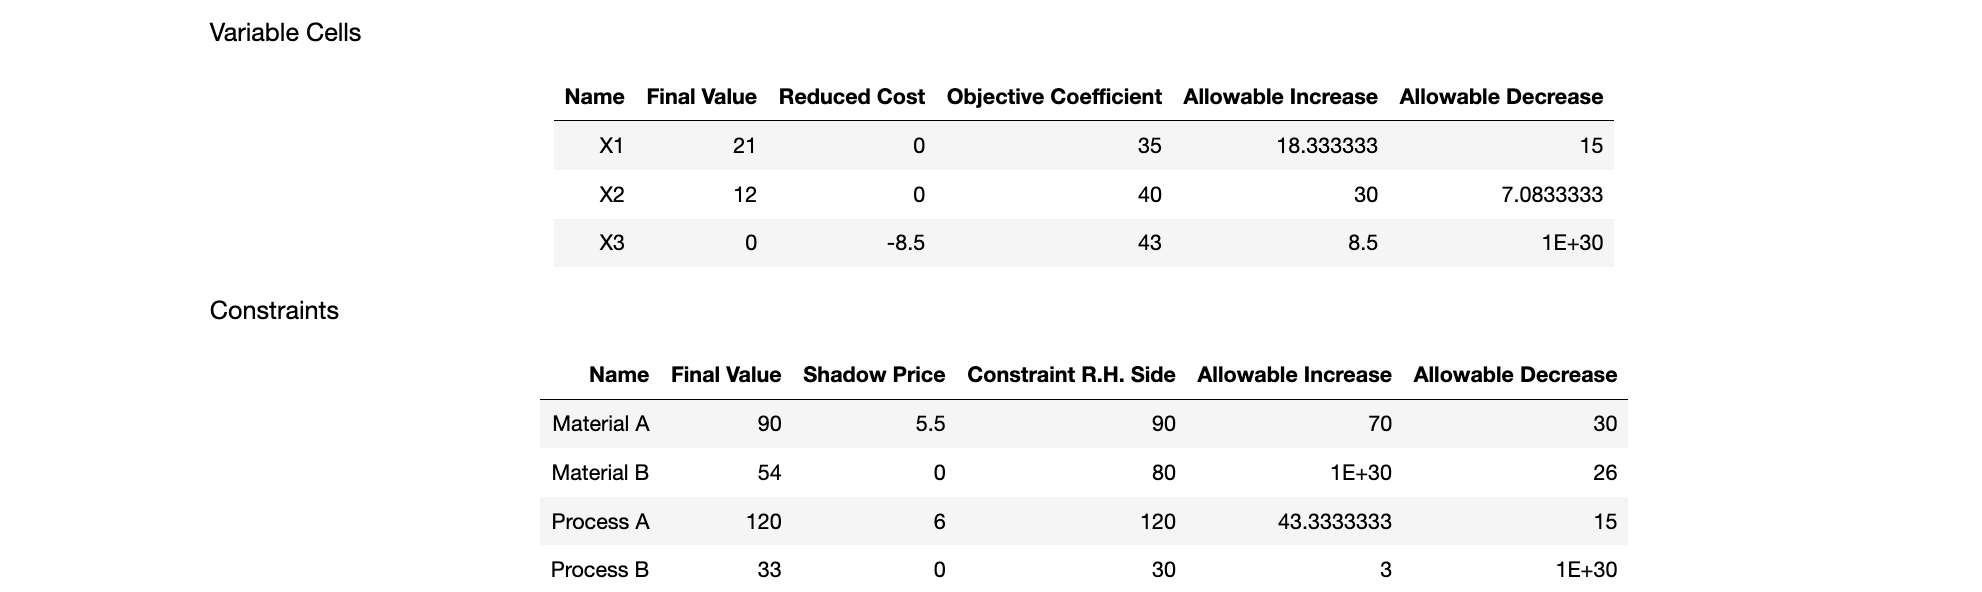

### Generate Sensitivity report via Python Gurobi

#### Code Sample 1: 
1. use loops to put in variables, constrains
2. applicable to large number of variables, constrains

In [103]:
import numpy as np
from gurobipy import Model, GRB, quicksum

var_names = ['X1', 'X2', 'X3']
# resources names
res_names = ['Material_A', 'Material_B', 'Process_A', 'Process_B']
profit = np.array([35, 40, 43])
res_used = np.array([[2,4,5], [2,1,3], [4,3,4], [1,1,2]])
res_avail = np.array([90, 80, 120, 30])
res_operater = ['<=', '<=', '<=', '>=']

n = len(profit) # number of variables
m = len(res_avail) # number of constraints

# create a new model
model = Model()

# set decision variables
X = model.addVars(n, name=var_names)

# set the bojective function
model.setObjective(quicksum(profit[j]*X[j] for j in range(n)), GRB.MAXIMIZE)

# add constraints
for i in range(m):
    LHS = quicksum(X[j]*res_used[i, j] for j in range(n))
    if res_operater[i] == '<=':
        model.addConstr(LHS <= res_avail[i], name=res_names[i])
    elif res_operater[i] == '>=':
        model.addConstr(LHS >= res_avail[i], name=res_names[i])


# optimize the model
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 19.6.0 19H2026)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 4 rows, 3 columns and 12 nonzeros
Model fingerprint: 0x9d602b89
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [4e+01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve time: 0.03s
Presolved: 4 rows, 3 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1800000e+32   5.625000e+30   1.180000e+02      0s
       2    1.2150000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.06 seconds (0.00 work units)
Optimal objective  1.215000000e+03


In [107]:
# Check if the model solved optimally
if model.status == GRB.OPTIMAL:
    print('Sensitivity Analysis (SA)\nObjVal =', model.ObjVal)
    model.printAttr(['X', 'RC', 'Obj', 'SAObjLow', 'SAObjUp'])
    model.printAttr(['Sense', 'Slack', 'Pi', 'RHS', 'SARHSLow', 'SARHSUp']) 
else:
    print("Model is not optimal.")

# Pi = shadow price = dual variable value
# NOTE: printAttr prints only rows with at least one NON-ZERO value, e.g. model.printAttr('X') prints only non-zero variable values

Sensitivity Analysis (SA)
ObjVal = 1215.0

    Variable            X           RC          Obj     SAObjLow      SAObjUp 
-----------------------------------------------------------------------------
          X1           21            0           35           20      53.3333 
          X2           12            0           40      32.9167           70 
          X3            0         -8.5           43         -inf         51.5 

  Constraint        Sense        Slack           Pi          RHS     SARHSLow      SARHSUp 
------------------------------------------------------------------------------------------
  Material_A            <            0          5.5           90           60          160 
  Material_B            <           26            0           80           54          inf 
   Process_A            <            0            6          120          105      163.333 
   Process_B            >           -3            0           30         -inf           33 


#### Code Sample 1: 
1. put in variables, constrains one by one
2. applicable to limited number of variables, constrains

In [79]:
from gurobipy import Model, GRB, quicksum

# create a new model
model = Model()

# set decision variables
X1 = model.addVar(name='X1')
X2 = model.addVar(name='X2')
X3 = model.addVar(name='X3')

# set the bojective function
model.setObjective(35*X1 + 40*X2 + 43*X3, GRB.MAXIMIZE)

# add constraints
model.addConstr(2*X1 + 4*X2 + 5*X3 <= 90, 'Material_A_Constraint')
model.addConstr(2*X1 + 1*X2 + 3*X3 <= 80, 'Material_B_Constraint')
model.addConstr(4*X1 + 3*X2 + 4*X3 <= 120, 'Process_A_Constraint')
model.addConstr(1*X1 + 1*X2 + 2*X3 >= 30, 'Process_B_Constraint')

# optimize the model
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 19.6.0 19H2026)

CPU model: Intel(R) Core(TM) i5-7360U CPU @ 2.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 4 rows, 3 columns and 12 nonzeros
Model fingerprint: 0x9d602b89
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [4e+01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve time: 0.01s
Presolved: 4 rows, 3 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1800000e+32   5.625000e+30   1.180000e+02      0s
       2    1.2150000e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.215000000e+03


In [81]:
print('Sensitivity Analysis (SA)\nObjVal =', model.ObjVal)
model.printAttr(['X', 'RC', 'Obj', 'SAObjLow', 'SAObjUp'])
model.printAttr(['Sense', 'Slack', 'Pi', 'RHS', 'SARHSLow', 'SARHSUp']) 
# Pi = shadow price = dual variable value
# NOTE: printAttr prints only rows with at least one NON-ZERO value, e.g. model.printAttr('X') prints only non-zero variable values

Sensitivity Analysis (SA)
ObjVal = 1215.0

    Variable            X           RC          Obj     SAObjLow      SAObjUp 
-----------------------------------------------------------------------------
          X1           21            0           35           20      53.3333 
          X2           12            0           40      32.9167           70 
          X3            0         -8.5           43         -inf         51.5 

  Constraint        Sense        Slack           Pi          RHS     SARHSLow      SARHSUp 
------------------------------------------------------------------------------------------
Material_A_Constraint            <            0          5.5           90           60          160 
Material_B_Constraint            <           26            0           80           54          inf 
Process_A_Constraint            <            0            6          120          105      163.333 
Process_B_Constraint            >           -3            0           30     

### Changing Objective Function Coeffients

* if one of objective coeffient changes within the range of optimality, and all other ones stay the same, then the optimal will remain the same
* 100% rule for multiple objective coeffient changes
    * if some objective coeffient changes within the range of optimality, and all other ones stay the same, then the optimal will remain the same if the toal percentage of allowable changes <= 100%

**Question:**

1. what if the objective coeffient of X1 increase by 5?

    * since the 35+5 is within the range of optimality [20, 53.3], so the current variable optimal solution remain the same (X1, X2, X3) = (21, 12, 0)
    * we can calculate the new optimal objective value is  40X1 + 40X2 + 43X3 = 1320

2. what if the objective coeffient of X1 decrease by 20?
    * since the 35-20=15 is lower than SAObjLow=20, so we say the current optimal solution might no longer be the optimal
    * if we decrease it by 15 to make it equal to SAObjLow=20, at this time the optimal solution remain the same, and the new optimal objective value is  20X1 + 40X2 + 43X3 = 900
    * when we decrease it by 20, solution (X1, X2, X3) = (21, 12, 0) might not be the optimal, but still feasible. 15X1 + 40X2 + 43X3 = 795, which is a lower bound on optimal obj function value
    * puting above two facts together, the optimal obj function value will be betweeen 795 and 900

3. what if the objective coeffient of X1 increase by 5 and X2 decrease by 5?
    * X1 = 35+5=40 within the range of optimality [20, 53.3], X2 = 40-5=35 within the range of optimality [32.9, 70], so the optimal solution stay the same
    * applying the 100% rule, inc/allowable.inc + dec./allowable.dec = 5/18.3 + 5/7.1 = 97.8%, so the optimal solution stay the same (X1, X2, X3) = (21, 12, 0)
    * calculate the optimal obj function value 40X1 + 35X2 + 43X3 = 1260

### Changing Right Hand Side Values

#### Difinition


**Slack** = |RHS - Final Value| = 'unused units of resource'

    slack of a constraint tells you how much "room" is left before the constraint becomes binding.

**Shadow Price** = Pi = dual value = margin value of having extra unit resouce = how much the objective function value change if the RHS increase by 1 unit

**Range of feasibility** = [RHS-allowable Decrease, RHS+allowable Increase] = [SARHSLow, SARHSUp]


#### A constraint is binding or non-binding



   * **binding** the solution lies exactly on the boundary of that constraint — the solution would not be feasible if the constraint were made any tighter.
   * **not binding** the constrain does not strictly restrict the optimal solution, the constraint has no margin value -- changing RHS does not change the objective value
   * if shadow price != 0 then the constraint is binding and LHS = RHS and slack = 0
   * if Slack = RHS - Final Value != 0 then the constraint is non-binding
   * if shadow price = 0 and Slack = RHS - Final Value = 0 then the constraint is binding or non-binding
   * we can never have shadow price != 0 and Slack != RHS - Final Value = 0

#### what if RHS value(s) change?

* if one RHS value changes within the range of feasibility, and all other coefficients remain the same, the obj function value increase (decrease) by Shadow Price * the increase (decrease) of RHS

* 100% rule for RHS values: 
    * if multiple RHS change within the Range of feasibility, and all other coeffients stay the same, then the change in optimal objective function value can be calculated using shadow price if the toal percentage of allowable changes <= 100%

Constraints

| Name | Final Value | Shadow Price | Constraint R.H. Side | Allowable Increase | Allowable Decrease |
    |------|------ |------ |------ |------ |------ |
    | Material A | 90 | 5.5 | 90 | 70 | 30 |
    | Material B | 54 | 0 | 80 | 1E+30 | 26 |
    | Process A | 120 | 6 | 120 | 43.3333333 | 15 |
    | Process B | 30 | 0 | 30 | 3 | 1E+30 |

#### Question



what if additional 50 Material A available?
    
   * +50 is within allowable increase for Material A, so the optimal objective value will increase 5.5*50 = 275
   * since we relax a binding constraint, the optimal solution and optimal obj value might change, and the old optimal solution still feasible

###  use case 1 of shadow price

you are offered 10 additional minutes of process A for a total of \$50. should you take the offer?


* allowable increase = 43.3, actual increase = 10
* increase in profit = 6*10 = 60
* Net Gain = 60-50=10
* Yes, we should take the offer

### use case 2 of shadow price

A potential Product 4 is being evaluated. it requires 3 units of Material A, 4 units of Material B, 2 units of Process A and 0 unit of Process B.

If product 4 is projected to generate a profit of \$35, should it be introduced?

* suppose one X4 is produced, Gain is \$35,cost is due to shift away from the old products t X4
* Net gain from one unit of X4 = unit profit 35 - cost of resource (3*SP1+4*SP2+2*SP3+0*SP4) = 35 - (3*5.5+4*0+2*6+0*0) = 6.5
* increase in profit = 6.5 per unit, so Yes, we should introduce Product 4

### another use case of shadow price and the meaning of reduced cost

Variable Cells

| Name | Final Value | Reduced Cost | Objective Coefficient | Allowable Increase | Allowable Decrease |
    |------|------|------|------|------|------|
    | X1 | 21 | 0 | 35 | 18.333333 | 15 |
    | X2 | 12 | 0 | 40 | 30 | 7.0833333 |
    | X3 | 0 | -8.5 | 43 | 8.5 | 1E+30 |


Constraints

| Name | Final Value | Shadow Price | Constraint R.H. Side | Allowable Increase | Allowable Decrease |
    |------|------ |------ |------ |------ |------ |
    | Material A | 90 | 5.5 | 90 | 70 | 30 |
    | Material B | 54 | 0 | 80 | 1E+30 | 26 |
    | Process A | 120 | 6 | 120 | 43.3333333 | 15 |
    | Process B | 33 | 0 | 30 | 3 | 1E+30 |

Interpret the reduced cost for X3. How can it be calculated?

* at optimal solution, we don't produce X3
* we would lose \$8.5 on profit for producing one X3
* if we really want to produce X3, we have to increase unit price of X3 at least $8.5

Maximize z = 35X1 + 40X2 + 43X3

s.t.

    2X1 + 4X2 + 5X3 <= 90  # Material A
    2X1 + 1X2 + 3X3 <= 80  # Material B
    4X1 + 3X2 + 4X3 <= 120 # Process A
    1X1 + 1X2 + 2X3 >= 30  # Process B
    X1, X2, X3, X4 >= 0

* suppose one X3 is produced, Gain is \$43,cost is due to shift away from the old products t X3
* Net gain from one unit of X3 = unit profit 43 - cost of resource (5*SP1+3*SP2+4*SP3+2*SP4) = 43 - (5*5.5+3*0+4*6+2*0) = -8.5
* -8.5 is the reduced cost for X3